# Project: Movies Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

### <a id='intro'></a>
## Introduction

The following report is an analysis based on the data provided by the Movies dataset. 

In this report, the following questions will be analyzed:

> 1-Are movies getting better in time?<br>
> 2-Is there a correlation between popularity and quality?<br>
> 3-What is the relationship between budget, revenue and quality?<br>
> 4-Do popular directors(10 or more pictures) make better movies than non-popular ones(less than 10 movies)?<br>
> 5-Do popular directors make more profitable movies?<br>

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline 
df = pd.read_csv('tmdb-movies.csv')
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


<a id='wrangling'></a>
## Data Wrangling

> In this section of the report, we will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. 

### General Properties

In [2]:
# General inspection of dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [3]:
#check for rows with incomplete financial data (budget or revenue = 0)
mask = (df['budget'] == 0) | (df['revenue'] == 0)
df.loc[mask]['id'].count()

7011

In [4]:
# Data contains several columns that will not be used in this analysis as well as rows with missing director information. All of these will be dropped.
#remove columns that are not necessary for this analysis.
df.drop(['runtime', 'overview', 'genres', 'keywords', 'tagline', 'homepage', 'tagline', 'cast', 'imdb_id', 'budget', 'revenue', 'production_companies', 'release_date','vote_count'], axis=1, inplace=True)


In [5]:
#drop rows with null director
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10822 entries, 0 to 10865
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10822 non-null  int64  
 1   popularity      10822 non-null  float64
 2   original_title  10822 non-null  object 
 3   director        10822 non-null  object 
 4   vote_average    10822 non-null  float64
 5   release_year    10822 non-null  int64  
 6   budget_adj      10822 non-null  float64
 7   revenue_adj     10822 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 760.9+ KB


In [6]:
#to simplify subsequent analysis, we will create a column for directors movie count
# This is not the most efficient code, but wanted to exemplify the use of a lambda function as per rubrics request
df['movies_by_director']=df['director'].apply(lambda x : df.query('director == @x')['id'].count())

In [7]:
#alternative method for directors movie count using merge, much faster than the previous one
df_dir_count = df.groupby('director').agg(movies_by_director_ii=('id','count'))
df=df.merge(df_dir_count,left_on='director',right_on='director')

In [8]:
#test if the two columns are the same, if both methods yield the same result the test will be full of trues...and no falses
test =pd.DataFrame(np.where(df['movies_by_director']==df['movies_by_director_ii'],True,False),columns=['test'])
test.groupby('test')['test'].count()

test
True    10822
Name: test, dtype: int64

In [9]:
#create column for popular director ("Yes" if movies_by_director >= 10)
df['polular_director']=np.where(df["movies_by_director"] >= 10, 'Yes', 'No')

In [10]:
#create column for profit margin, note that many movies are missing financial data. this line tests that budget>0
df['profit_margin']= np.where(df["budget_adj"] > 0,(df['revenue_adj']-df['budget_adj'])/df['budget_adj'],0)
df.head()

,id,popularity,original_title,director,vote_average,release_year,budget_adj,revenue_adj,movies_by_director,movies_by_director_ii,polular_director,profit_margin
0,135397,32.985763,Jurassic World,Colin Trevorrow,6.5,2015,1.379999e+08,1.392446e+09,2,2,No,9.090192
1,84332,0.408010,Safety Not Guaranteed,Colin Trevorrow,6.7,2012,7.123082e+05,3.806378e+06,2,2,No,4.343723
2,76341,28.419936,Mad Max: Fury Road,George Miller,7.1,2015,1.379999e+08,3.481613e+08,8,8,No,1.522909
3,65759,0.930920,Happy Feet Two,George Miller,5.8,2011,1.260217e+08,1.458037e+08,8,8,No,0.156973
4,9836,1.411147,Happy Feet,George Miller,5.8,2006,1.081669e+08,4.157240e+08,8,8,No,2.843356


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1:Are movies getting better in time?
To assess this question we will use a scatter plot with a regression line, with time in the x axis and quality (as expressed by vote average) on the y axis. <br>

<Axes: title={'center': 'Movie quality evolution'}, xlabel='release_year', ylabel='vote_average'>

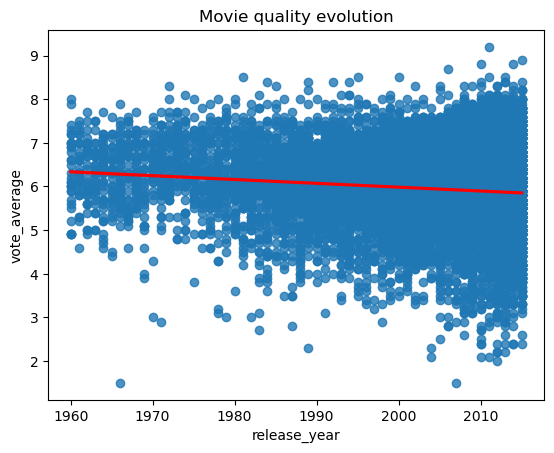

In [11]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
plt.title("Movie quality evolution")
sns.regplot(
    data=df,x="release_year",y="vote_average",
    line_kws=dict(color="r")
)

A negative trend is observed whilst variability increases in time. 

### Research Question 2: Is there a correlation between popularity and quality?
To assess this question we will use a scatter plot with a regression line, with popularity in the x axis and quality (as expressed by vote average) on the y axis. <br>

<Axes: title={'center': 'Correlation between perceived quality and popularity'}, xlabel='popularity', ylabel='vote_average'>

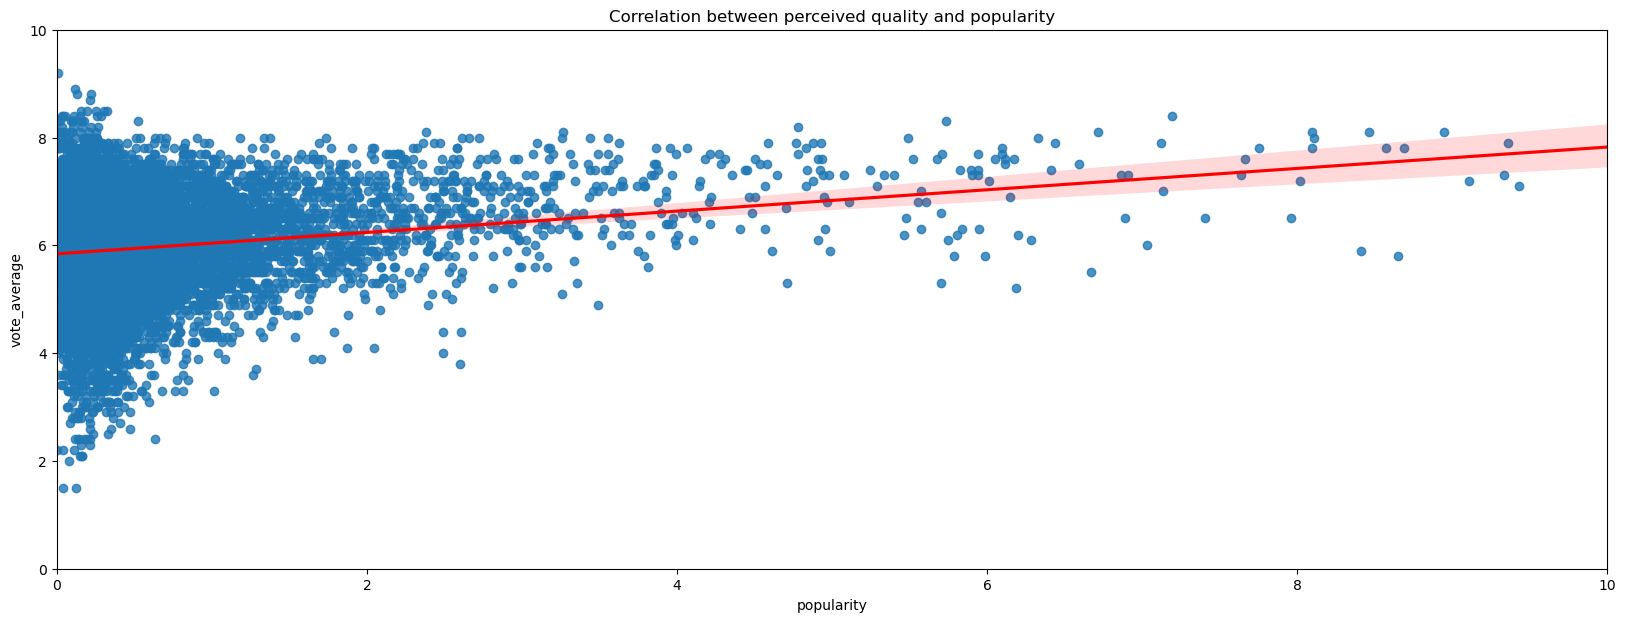

In [12]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
plt.figure(figsize=(20,7))
plt.ylim([0,10])
plt.xlim([0,10])
plt.title("Correlation between perceived quality and popularity")
sns.regplot(
    data=df,x="popularity",y="vote_average",
    line_kws=dict(color="r")
)


The chart shows a positive correlation, with very high variability in quality scores for the movies with the lowest popularity.

### Research Question3: What is the relationship between budget, revenue and quality?

As discussed earlier, a significant number of movies lack accurate financial data. These movies will be excluded from this question's analysis. Given the broad range of budget, we will split the next two charts in to for easier visualization.

In [13]:
#for this question we will create a df that excludes movies with budget 0 and revenue 0
df2=df[['original_title','budget_adj','revenue_adj','vote_average']]
df2 = df2[df2.revenue_adj != 0]
df2 = df2[df2.budget_adj != 0]
df2.sort_values('budget_adj',ascending=True).head()

,original_title,budget_adj,revenue_adj,vote_average
6891,"Love, Wedding, Marriage",0.969398,1335.830503,5.3
5824,Lost & Found,1.309053,130.905285,4.8
5378,Boy,3.000000,43.000000,7.3
3589,Death Wish 2,4.519285,36.154278,5.6
4661,Tales from the Darkside: The Movie,5.006696,26.702377,5.8


<Axes: xlabel='budget_adj', ylabel='revenue_adj'>

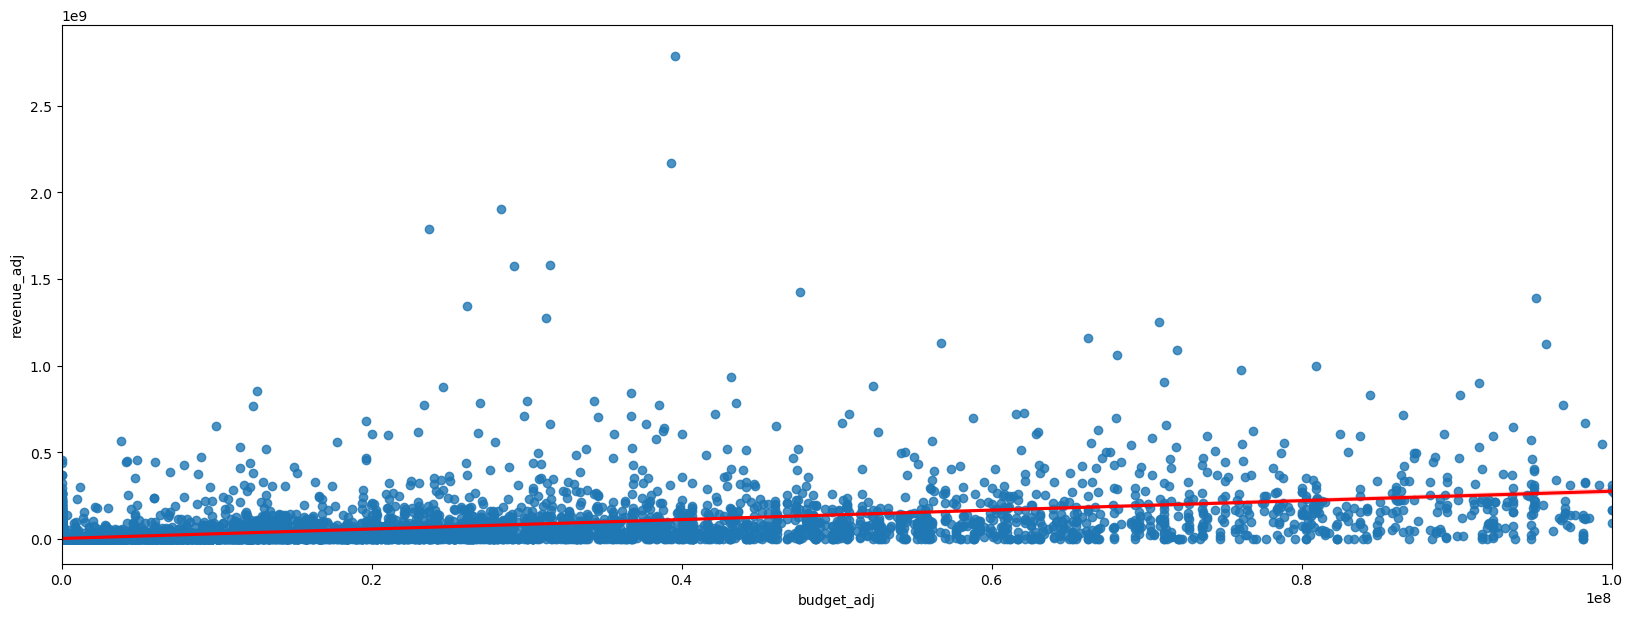

In [14]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
plt.figure(figsize=(20,7))
plt.xlim([0,100000000])
sns.regplot(data=df,x="budget_adj",y="revenue_adj",line_kws=dict(color="r"))


<Axes: xlabel='budget_adj', ylabel='revenue_adj'>

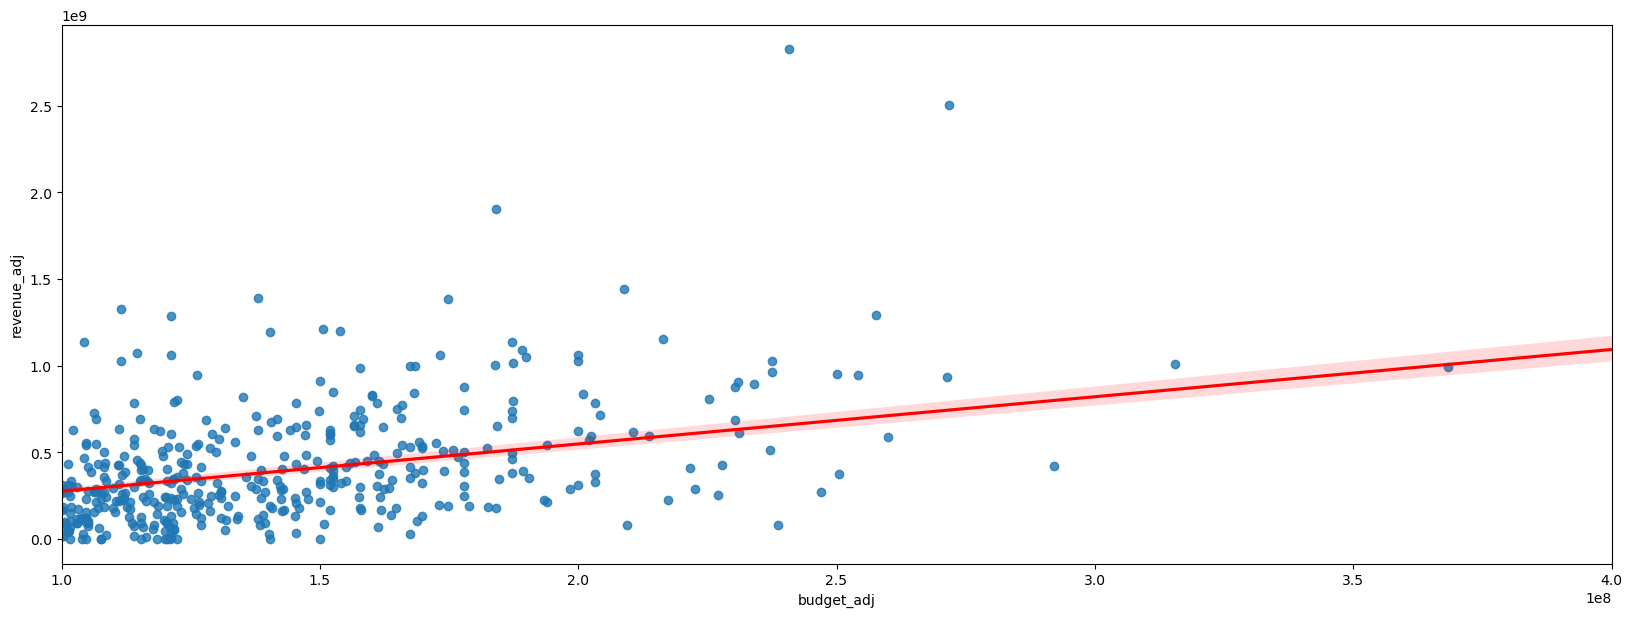

In [15]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
plt.figure(figsize=(20,7))
plt.xlim([100000000,400000000])
sns.regplot(data=df,x="budget_adj",y="revenue_adj",line_kws=dict(color="r"))


A positive trend is observed in the correlation between revenue and budget. 

<Axes: xlabel='budget_adj', ylabel='vote_average'>

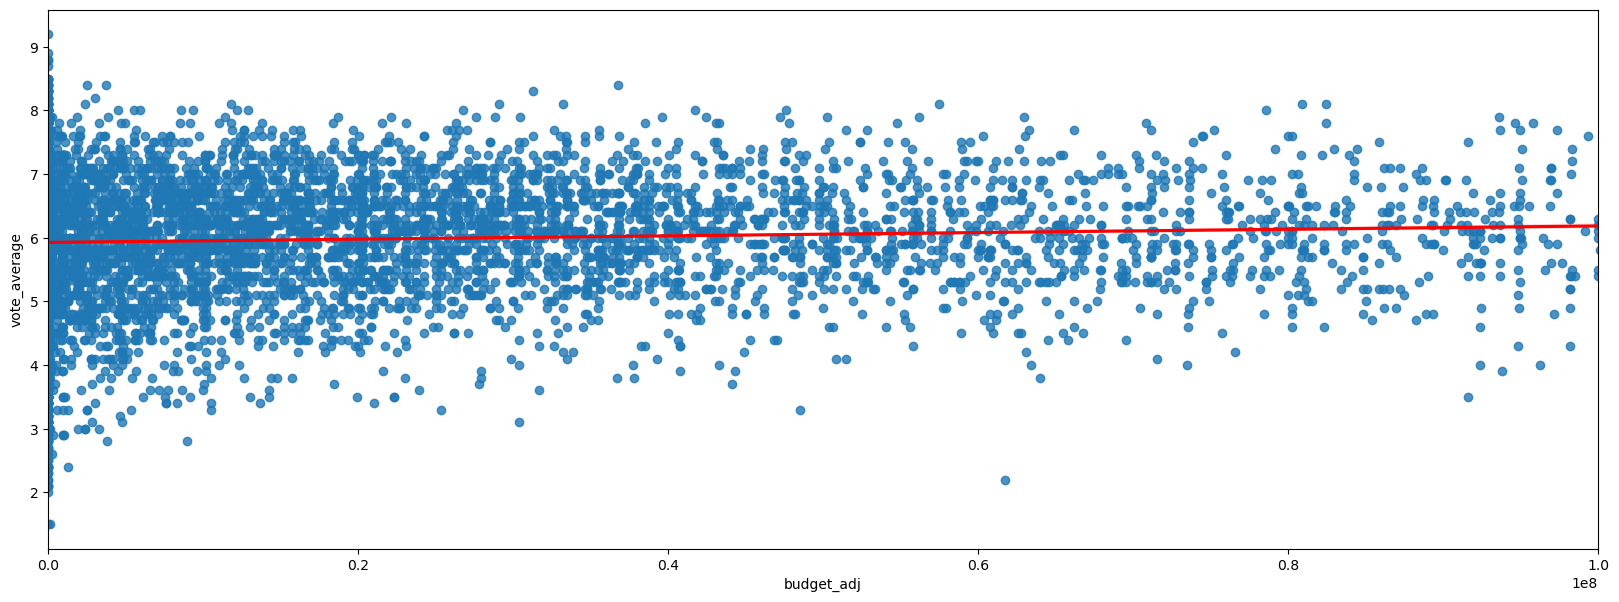

In [16]:
plt.figure(figsize=(20,7))
plt.xlim([0,100000000])
sns.regplot(data=df,x="budget_adj",y='vote_average',line_kws=dict(color="r"))

<Axes: xlabel='budget_adj', ylabel='vote_average'>

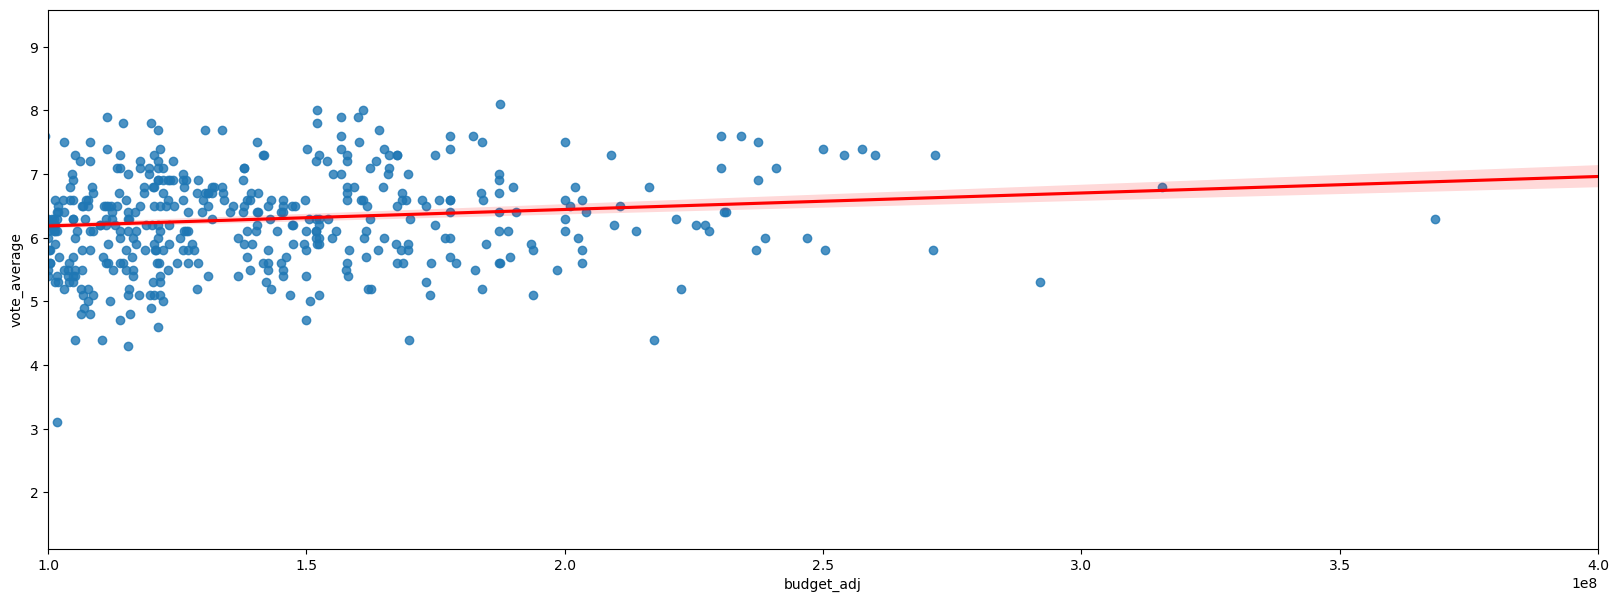

In [17]:
plt.figure(figsize=(20,7))
plt.xlim([100000000,400000000])
sns.regplot(data=df,x="budget_adj",y='vote_average',line_kws=dict(color="r"))

We observe a marginally positive trend between budget and quality.

C:\Users\Diego.Lythgoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Diego.Lythgoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Diego.Lythgoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='polular_director', ylabel='vote_average'>

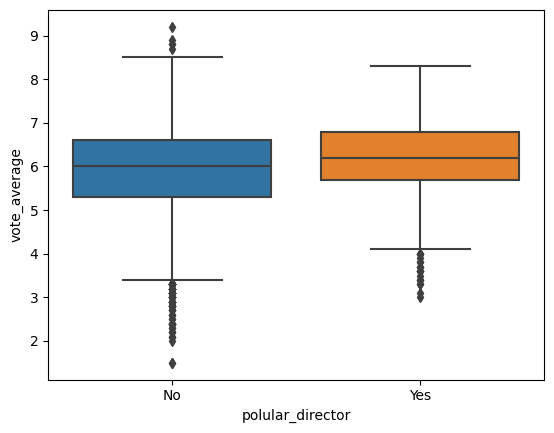

In [18]:
sns.boxplot(data=df,x="polular_director", y="vote_average")

C:\Users\Diego.Lythgoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Diego.Lythgoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Diego.Lythgoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='polular_director', ylabel='profit_margin'>

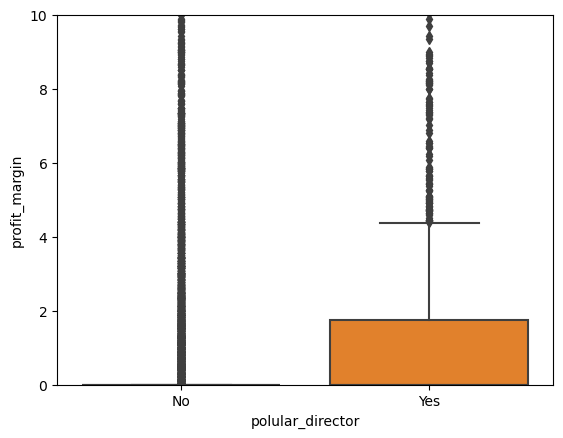

In [19]:
plt.ylim([0,10])
sns.boxplot(data=df,x="polular_director", y="profit_margin")

<a id='conclusions'></a>
## Conclusions

The following are the conclusions obtained based on the data analysed. <br>

1-Are movies getting better in tim?   <br>
Based on the data provided, we notice that there is a slight negative trend in movie quality as expresed by vote averages. Morover, an increased in data dispersion is observed, with an increasing number of worse and better rated quality movies in recent years. <br> <br>?
2-Is there a correlation between popularity and quali? <br>
A positive correlation between popularity and movie quality as per vote average is observed. This correlation is more clear for popularity rates above 1, where dispersion becomes less evident. <br>
?
3-What is the relationship between budgerevenuefit and quali <br>
Before answering this question, it is important to notice that a significant number of movies do have incomplete financial data(7011) either budget or revenue missing data. These movies were dropped from the analysis and therefore trends could change if the dataset could be completed.<br>
With that said, the observation is that for the available data, that there is a positive correlation between adjusted budget and revenue. Hoewever, the correlation between butget and quality is virtually non existant.<br>ty?
4-Do popular directors(10 or more pictures) make better movies than non-popular ones(less than 10 movi <br>
Popular directors produce movies with only a marginally higher quality as expressed by average votes.<br>es)?
5-Do popular directors make more profitable mo <br>
Based on the data provided, popular directors tend to produce movies that deliver higher profit margins.<br>viions!